In [1]:
import tensorflow as tf
tf.random.set_seed(42)

## Load data

In [2]:
# Import the dataset loading function from sklearn
from sklearn.datasets import fetch_california_housing

# Load the California housing dataset
house_dataset = fetch_california_housing()

# Display the oringal data
house_dataset.keys()

# Import pandas package to format the data
import pandas as pd

# Extract features with their names into the a dataframe format
data = pd.DataFrame(house_dataset.data, columns=house_dataset.feature_names)

# Extract target with their names into a pd.Series object with name MEDV
target = pd.Series(house_dataset.target, name = 'MEDV')

# Visualize the first 5 samples of the data
data.head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [3]:
# Split data into training and test dataset
from sklearn.model_selection import train_test_split
train_data, test_data, train_targets, test_targets = train_test_split(data, target, test_size=0.2, random_state=42)

# Check the shape of whole dataset and the splited training and test set
print("--Shape of the whole data--\n {}".format(data.shape))
print("\n--Shape of the target vector--\n {}".format(target.shape))
print("\n--Shape of the training data--\n {}".format(train_data.shape))
print("\n--Shape of the testing data--\n {}".format(test_data.shape))

--Shape of the whole data--
 (20640, 8)

--Shape of the target vector--
 (20640,)

--Shape of the training data--
 (16512, 8)

--Shape of the testing data--
 (4128, 8)


In [4]:
train_data.shape, test_data.shape

((16512, 8), (4128, 8))

In [5]:
train_data

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
14196,3.2596,33.0,5.017657,1.006421,2300.0,3.691814,32.71,-117.03
8267,3.8125,49.0,4.473545,1.041005,1314.0,1.738095,33.77,-118.16
17445,4.1563,4.0,5.645833,0.985119,915.0,2.723214,34.66,-120.48
14265,1.9425,36.0,4.002817,1.033803,1418.0,3.994366,32.69,-117.11
2271,3.5542,43.0,6.268421,1.134211,874.0,2.300000,36.78,-119.80
...,...,...,...,...,...,...,...,...
11284,6.3700,35.0,6.129032,0.926267,658.0,3.032258,33.78,-117.96
11964,3.0500,33.0,6.868597,1.269488,1753.0,3.904232,34.02,-117.43
5390,2.9344,36.0,3.986717,1.079696,1756.0,3.332068,34.03,-118.38
860,5.7192,15.0,6.395349,1.067979,1777.0,3.178891,37.58,-121.96


## Data Preparation: normalization

In [6]:
def norm(x, mean, std):
    return (x - mean) / std

mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

normed_train_data = norm(train_data, mean, std)
normed_test_data = norm(test_data, mean, std)

## Build up an MLP

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[8]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
    ])

In [8]:
# Now try out the model. Take a batch of 5 examples from the training data and call model.predict on it.
example_batch = normed_train_data[:5]
example_result = model.predict(example_batch)
example_result

array([[-0.16246818],
       [-0.19748914],
       [ 0.06278764],
       [-0.18101668],
       [-0.04015784]], dtype=float32)

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                576       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,801
Trainable params: 4,801
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Customize the optimizer configuration (learning rate here)
optimizer = tf.keras.optimizers.RMSprop(0.01)
model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])

### Train & test the model

In [11]:
model.fit(normed_train_data, train_targets, epochs=300, batch_size=1024, verbose=1)

Epoch 1/300
17/17 [==============================] - 2s 7ms/step - loss: 1.2357 - mae: 0.7693 - mse: 1.2357
Epoch 2/300
17/17 [==============================] - 0s 7ms/step - loss: 0.6065 - mae: 0.5577 - mse: 0.6065
Epoch 3/300
17/17 [==============================] - 0s 8ms/step - loss: 0.5543 - mae: 0.5341 - mse: 0.5543
Epoch 4/300
17/17 [==============================] - 0s 8ms/step - loss: 0.4915 - mae: 0.5030 - mse: 0.4915
Epoch 5/300
17/17 [==============================] - 0s 9ms/step - loss: 0.4523 - mae: 0.4822 - mse: 0.4523
Epoch 6/300
17/17 [==============================] - 0s 7ms/step - loss: 0.4800 - mae: 0.4997 - mse: 0.4800
Epoch 7/300
17/17 [==============================] - 0s 9ms/step - loss: 0.4242 - mae: 0.4639 - mse: 0.4242
Epoch 8/300
17/17 [==============================] - 0s 8ms/step - loss: 0.4498 - mae: 0.4811 - mse: 0.4498
Epoch 9/300
17/17 [==============================] - 0s 8ms/step - loss: 0.4173 - mae: 0.4620 - mse: 0.4173
Epoch 10/300
17/17 [========

In [12]:
loss, mae, mse = model.evaluate(normed_test_data, test_targets, verbose=0)
mse

0.30622154474258423

### Tune the number of epochs

In [13]:
# Train the model (in silent mode, verbose=0)

def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[normed_train_data.shape[1]]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
        ])
    optimizer = tf.keras.optimizers.RMSprop(0.01)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
    return model

model = build_model()

EPOCHS=500
history = model.fit(normed_train_data, train_targets,
                    validation_split = 0.2,
                    epochs=EPOCHS, batch_size=1024, verbose=1)

Epoch 1/500
13/13 [==============================] - 1s 18ms/step - loss: 1.3889 - mae: 0.8297 - mse: 1.3889 - val_loss: 0.6718 - val_mae: 0.6131 - val_mse: 0.6718
Epoch 2/500
13/13 [==============================] - 0s 6ms/step - loss: 0.6545 - mae: 0.5861 - mse: 0.6545 - val_loss: 0.4939 - val_mae: 0.4885 - val_mse: 0.4939
Epoch 3/500
13/13 [==============================] - 0s 6ms/step - loss: 0.5937 - mae: 0.5618 - mse: 0.5937 - val_loss: 0.5527 - val_mae: 0.5600 - val_mse: 0.5527
Epoch 4/500
13/13 [==============================] - 0s 6ms/step - loss: 0.5149 - mae: 0.5218 - mse: 0.5149 - val_loss: 0.6927 - val_mae: 0.5765 - val_mse: 0.6927
Epoch 5/500
13/13 [==============================] - 0s 7ms/step - loss: 0.5077 - mae: 0.5154 - mse: 0.5077 - val_loss: 0.6173 - val_mae: 0.5935 - val_mse: 0.6173
Epoch 6/500
13/13 [==============================] - 0s 6ms/step - loss: 0.4915 - mae: 0.5079 - mse: 0.4915 - val_loss: 0.4806 - val_mae: 0.4793 - val_mse: 0.4806
Epoch 7/500
13/13 [==

In [14]:
import pandas as pd
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
495,0.162589,0.285757,0.162589,0.351760,0.391091,0.351760,495
496,0.153573,0.279464,0.153573,0.346292,0.377510,0.346292,496
497,0.153613,0.277982,0.153613,0.341311,0.374854,0.341311,497
498,0.159570,0.283553,0.159570,0.350569,0.395264,0.350569,498
499,0.159269,0.284903,0.159269,0.340618,0.373453,0.340618,499


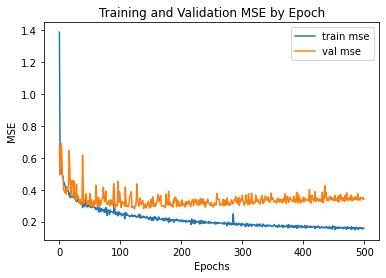

In [15]:
import matplotlib.pyplot as plt

plt.plot(hist['epoch'], hist['mse'], label = "train mse")
plt.plot(hist['epoch'], hist['val_mse'], label = "val mse")
plt.xlabel('Epochs')
plt.ylabel('MSE')
# Set a title of the current axes.
plt.title('Training and Validation MSE by Epoch')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [16]:
import numpy as np
def smooth_curve(values, std=5):
    # gaussian smoothing: Smooths a list of values by convolving with a gussian.
    width = std * 4
    x = np.linspace(-width, width, 2 * width + 1)
    kernel = np.exp(-(x / 5)**2)

    values = np.array(values)
    weights = np.ones_like(values)

    smoothed_values = np.convolve(values, kernel, mode='same')
    smoothed_weights = np.convolve(weights, kernel, mode='same')

    return smoothed_values / smoothed_weights

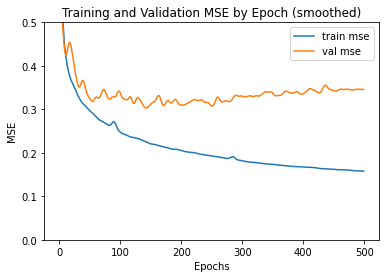

In [17]:
import matplotlib.pyplot as plt

plt.plot(hist['epoch'], smooth_curve(hist['mse']), label = "train mse")
plt.plot(hist['epoch'], smooth_curve(hist['val_mse']), label = "val mse")
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.ylim((0, 0.5)) 
# Set a title of the current axes.
plt.title('Training and Validation MSE by Epoch (smoothed)')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

## Final fit model with full data & test model

In [18]:
model = build_model()
model.fit(normed_train_data, train_targets, epochs=150, batch_size=1024, verbose=1)

Epoch 1/150
17/17 [==============================] - 1s 4ms/step - loss: 1.2228 - mae: 0.7754 - mse: 1.2228
Epoch 2/150
17/17 [==============================] - 0s 4ms/step - loss: 0.5924 - mae: 0.5523 - mse: 0.5924
Epoch 3/150
17/17 [==============================] - 0s 4ms/step - loss: 0.5769 - mae: 0.5535 - mse: 0.5769
Epoch 4/150
17/17 [==============================] - 0s 4ms/step - loss: 0.4854 - mae: 0.5026 - mse: 0.4854
Epoch 5/150
17/17 [==============================] - 0s 4ms/step - loss: 0.4623 - mae: 0.4890 - mse: 0.4623
Epoch 6/150
17/17 [==============================] - 0s 4ms/step - loss: 0.4560 - mae: 0.4858 - mse: 0.4560
Epoch 7/150
17/17 [==============================] - 0s 4ms/step - loss: 0.4390 - mae: 0.4749 - mse: 0.4390
Epoch 8/150
17/17 [==============================] - 0s 4ms/step - loss: 0.4266 - mae: 0.4702 - mse: 0.4266
Epoch 9/150
17/17 [==============================] - 0s 4ms/step - loss: 0.4237 - mae: 0.4663 - mse: 0.4237
Epoch 10/150
17/17 [========

In [19]:
loss, mae, mse = model.evaluate(normed_test_data, test_targets, verbose=0)
mse

0.3533508777618408

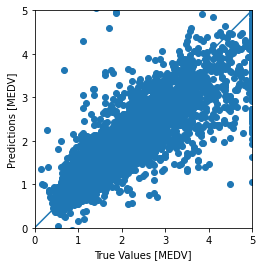

In [20]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_targets, test_predictions)
plt.xlabel('True Values [MEDV]')
plt.ylabel('Predictions [MEDV]')
lims = [0, 5]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)